Importation of modules and functions
===

In [15]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

#the autoreload
%load_ext autoreload
%autoreload 2

# set random seed
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data loading
===

In [16]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")

# Select portion of data 

In [3]:
labels_raw_portion = labels_raw[:10000]
data_raw_portion = data_raw[:10000,:]
ids_raw_portion = ids_raw[:10000]

Data filtering and standardization
===

In [17]:
data_, labels, ids, idx_colrem = process_data(data_raw, labels_raw, ids_raw, zero = False)
data, means, variance = standardize(data_)

The original dimensions of the training data set was 250000 samples and 30 columns. After feature and sample filtering, there are 223877 samples and 23 columns


Splitting into train and test set
===

In [18]:
X_train, y_train, X_test, y_test = split_data(data, labels)

print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the ratio of 0.8')

Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the ratio of 0.8


Linear regression with gradient descent (GD)
===

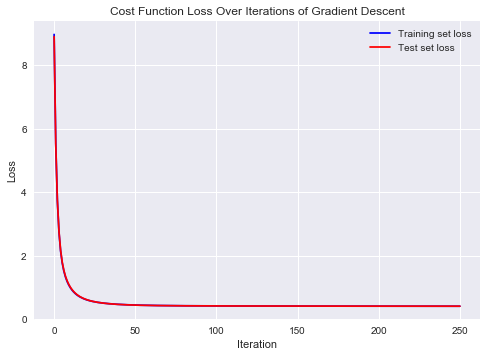

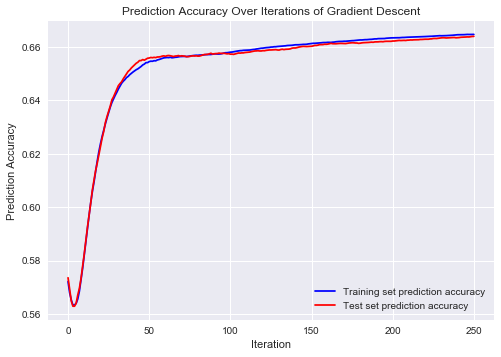

In [6]:
# initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_GD(y_train, X_train, initial_w, max_iters = 250) # fit model and retrieve W's across iterations
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()


Linear regression with stochastic gradient descent (SGD)
===

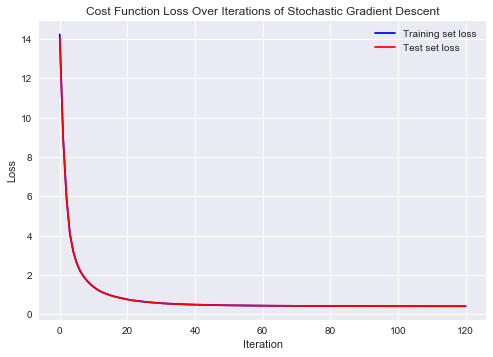

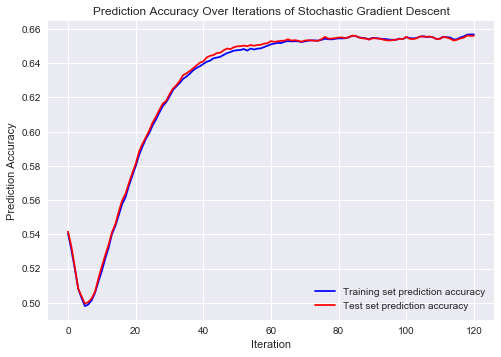

In [23]:
#initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_SGD(y_train, X_train, initial_w, max_iters = 250, tol = 1e-4, patience = 5) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Stochastic Gradient Descent')
plt.show()


Linear regression using least squares normal equations
===

In [24]:
w = least_squares(y_train, X_train)

pred_y = predict_labels(w, X_test)
pred_accuracy(pred_y,y_test)

0.6662944434518492

Linear regression using the normal equations with additional polynomial degrees
===

degree: 1 	 rmse_ts: 0.8712822459555415 	  pred_ts: 0.629198677863141
degree: 2 	 rmse_ts: 1.3079025508113666 	  pred_ts: 0.6602867607646954
degree: 3 	 rmse_ts: 8.658489449003552 	  pred_ts: 0.6763221368590316
degree: 4 	 rmse_ts: 72.26051138816247 	  pred_ts: 0.6810121493657316
degree: 5 	 rmse_ts: 556.3574282443082 	  pred_ts: 0.6822851527604074
degree: 6 	 rmse_ts: 3895.109690524784 	  pred_ts: 0.684920493121315
degree: 7 	 rmse_ts: 64437.52962892504 	  pred_ts: 0.6948365195640521
degree: 8 	 rmse_ts: 4265933.4964608 	  pred_ts: 0.7066732177952475
degree: 9 	 rmse_ts: 178033132.20876563 	  pred_ts: 0.7123235661961765
degree: 10 	 rmse_ts: 1793095991.9349306 	  pred_ts: 0.7123905663748437
degree: 11 	 rmse_ts: 224544547653.80377 	  pred_ts: 0.7152269072717528
degree: 12 	 rmse_ts: 2451908962331.8477 	  pred_ts: 0.7197605860282295
degree: 13 	 rmse_ts: 73266784372212.88 	  pred_ts: 0.7238252635340361
degree: 14 	 rmse_ts: 1883323771793062.5 	  pred_ts: 0.7155619081650885
degree: 15 	

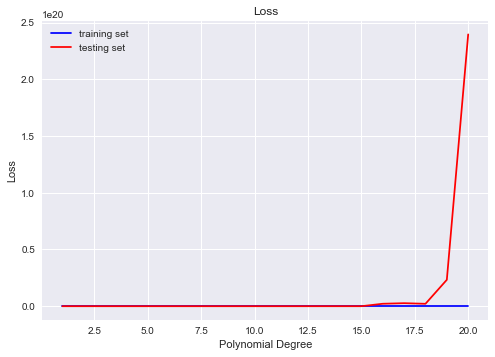

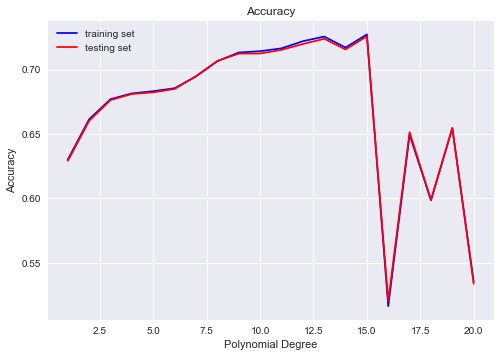

In [29]:
degrees = range(1,21)
rmse_tr = np.zeros(len(degrees))
rmse_ts = np.zeros(len(degrees))
pred_tr = np.zeros(len(degrees))
pred_ts = np.zeros(len(degrees))


for ind, degree in enumerate(degrees):
    #train the model
    X_test_poly = build_poly(X_test,degree)
    X_train_poly = build_poly(X_train,degree)
    w = least_squares(y_train, X_train_poly)
    rmse_tr[ind] = (np.sqrt(2 * compute_loss(y_train, X_train_poly, w)))
    pred_tr[ind] = pred_accuracy(predict_labels(w,X_train_poly),y_train)
    
    #test the model
    
    rmse_ts[ind] = (np.sqrt(2 * compute_loss(y_test, X_test_poly, w)))
    pred_ts[ind] = (pred_accuracy(predict_labels(w, X_test_poly),y_test))
    
    # print the update
    print("degree: {d} \t rmse_ts: {a} \t  pred_ts: {b}".format(d = degree, a = rmse_ts[ind], b = pred_ts[ind]))


    

# plot the loss
plt.style.use('seaborn')
plt.plot(degrees,rmse_tr, c='blue')
plt.plot(degrees,rmse_ts, c='red')
plt.title('Loss')
plt.xlabel('Polynomial Degree')
plt.ylabel('Loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


#plot the accuracy
plt.style.use('seaborn')
plt.plot(degrees,pred_tr, c='blue')
plt.plot(degrees,pred_ts, c='red')
plt.title('Accuracy')
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


Linear regression using ridge regression
===

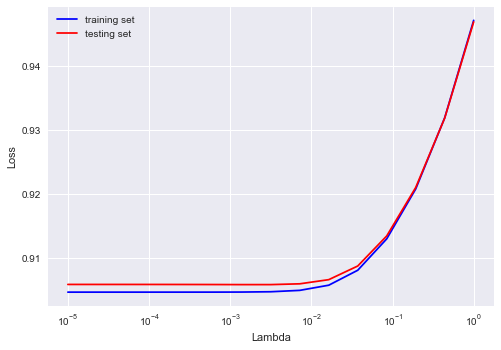

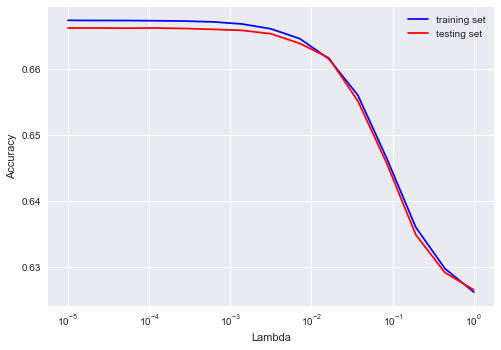

In [30]:
lambdas = np.logspace(-5, 0, 15)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train, lambda_)
    rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train),y_train))
    
    
    rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test),y_test))
    
plt.style.use('seaborn')
plt.semilogx(lambdas,rmse_tr, c='blue')
plt.semilogx(lambdas,rmse_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

# print(np.max(pred))

# Logistic regression

C:\Users\remy\Documents\machine_learning\project_1\implementations.py:17: RuntimeWarning: divide by zero encountered in log
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))
C:\Users\remy\Documents\machine_learning\project_1\implementations.py:17: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))


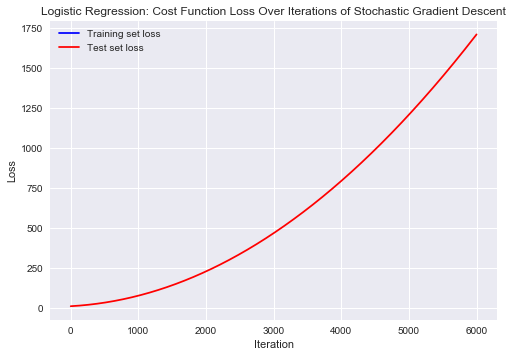

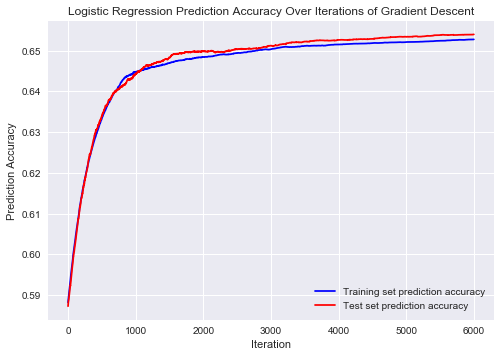

In [31]:
initial_w = np.random.rand(X_train.shape[1])
losses, ws = logistic_regression(y_train, X_train, initial_w, method = 'gd', max_iters = 6000) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()

# Regularized Logistic Regression

/Users/halimaschede/Documents/GitHub/machine_learning/project_1/implementations.py:21: RuntimeWarning: divide by zero encountered in log
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))) + 0.5 * lam * np.linalg.norm(w)) ** 2
/Users/halimaschede/Documents/GitHub/machine_learning/project_1/implementations.py:21: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))) + 0.5 * lam * np.linalg.norm(w)) ** 2


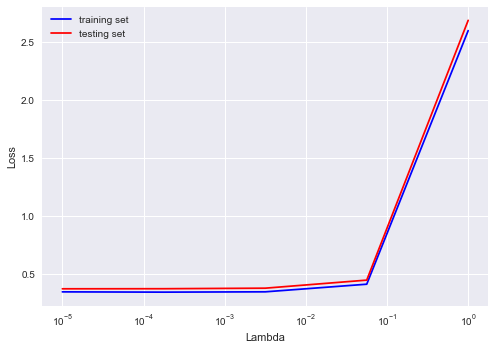

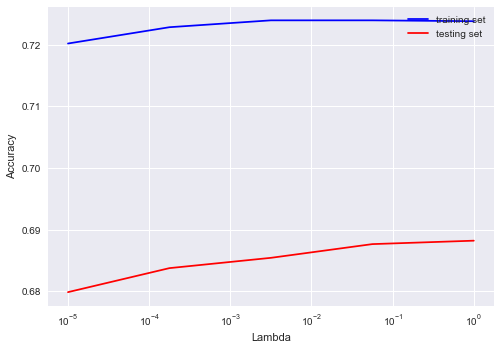

In [24]:
lambdas = np.logspace(-5, 0, 5)
loss_tr = []
loss_ts = []
pred_tr = []
pred_ts = []
initial_w = np.random.rand(X_train.shape[1])

# There is a runtime warning but just be patient

for ind, lambda_ in enumerate(lambdas):
    
    losses, ws = reg_logistic_regression(y_train, X_train, initial_w, lamb = lambda_, methods ='gd', gamma = 0.01, max_iters=6000)
    loss_tr.append(losses[-1])
    best_w = ws[-1]
    
    pred_tr.append(pred_accuracy(predict_labels(best_w, X_train),y_train))
    
    test_losses = compute_loss(y_test, X_test, best_w, lam = lambda_, method = 'reg_logistic') # retrieve losses using test set with ws
    loss_ts.append(test_losses)
    pred_ts.append(pred_accuracy(predict_labels(best_w, X_test),y_test))

    
plt.style.use('seaborn')
plt.semilogx(lambdas,loss_tr, c='blue')
plt.semilogx(lambdas,loss_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

####


In [21]:
# lamb = 0.1
# losses, ws = reg_logistic_regression(y_train, X_train, 
#                          initial_w, lamb, methods = 'gd', 
#                          gamma = 0.01, max_iters= 6000)

# test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, lam = lamb, method = 'reg_logistic'), ws)) # retrieve losses using test set with ws
# plt.style.use('seaborn')
# plt.plot(losses, label='Training set loss', c='blue')
# plt.plot(test_losses, label='Test set loss', c='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Regularized Logistic Regression: Cost Function Loss Over Iterations of Gradient Descent')
# plt.legend()
# plt.show()

# # Make plot with label prediction accuracy

# pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
# pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
# pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
# pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


# plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
# plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Prediction Accuracy')
# plt.title('Regularized Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
# plt.show()

# Preparing the prediction for kaggel

In [33]:
(labels_test, data_test, ids_test) = load_csv_data("data/test.csv")
data_test =  np.delete(data_test, idx_colrem, 1)  
data_test[data_test == -999] = np.nan

In [36]:
column_means = np.nanmean(data_test, axis=0)

# Variable containing locations of NaN in data frame
inds = np.where(np.isnan(data_test)) 
    
# Reassign locations of NaN to the column means
data_test[inds] = np.take(column_means, inds[1])

### Using the polynomial model

In [37]:
degree = 12
X_test_poly = build_poly(data_test,degree)
X_train_poly = build_poly(data,degree)
w = least_squares(labels, X_train_poly)
rmse_tr = (np.sqrt(2 * compute_loss(labels, X_train_poly, w)))
pred_tr = pred_accuracy(predict_labels(w,X_train_poly),labels)

test_prediction = predict_labels(w, X_test_poly)
    

In [40]:
name = "prediction.csv"
ids = ids_test
y_pred = test_prediction
create_csv_submission(ids, y_pred, name)

In [39]:
print(test_prediction)

[-1. -1. -1. ... -1. -1. -1.]


### Using logistic regression